In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import random

In [3]:
def fill_with_mode(column = None):
    """
    Função para preencher valores ausentes de uma coluna com a moda.
    Se houver mais de uma moda, escolhe aleatoriamente uma delas.
    """
    fill_column = column.copy()
    modas = column.mode()
    if len(modas) == 1:
        fill_column = fill_column.fillna(modas[0])
        return fill_column
    
    fill_column = fill_column.fillna(random.choice(modas))
    return fill_column

In [4]:
def calculate_outliers(df = None):
    """
    Função para calcular os outliers de um dataframe.
    Retorna um dataframe com a quantidade e a porcentagem de outliers por coluna numérica.
    """
    if df is None:
        raise ValueError("O dataframe não pode ser None.")
    if not isinstance(df, pd.DataFrame):
        raise TypeError("O argumento df deve ser um dataframe do pandas.")
    
    numerical_columns = df.select_dtypes(include=['int','float']).columns.tolist()
    outliers = []

    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        mask = (df[column] < lower_limit) | (df[column] > upper_limit)
        qtd_outliers = mask.sum()
        percentage_outliers = (qtd_outliers / df[column].size) * 100
        outliers.append({
            'Column': column,
            'Qtd_outliers': qtd_outliers,
            'Percentage_outliers': percentage_outliers,
        })

    return pd.DataFrame(outliers)

In [5]:
train = pd.read_csv('../../dataset/train.csv')

#Seção 1: Análise Exploratória Inicial"

In [6]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
train[['Age','SibSp','Fare','Parch']].describe()

,Age,SibSp,Fare,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,32.204208,0.381594
std,14.526497,1.102743,49.693429,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,31.000000,0.000000
max,80.000000,8.000000,512.329200,6.000000


In [8]:
sumario_vazios = pd.DataFrame({
    'Coluna': train.columns,
    'Quantidade': train.isnull().sum(axis=0).values,
    'Porcentagem': (train.isnull().mean() * 100).round(2).values
})
sumario_vazios

,Coluna,Quantidade,Porcentagem
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,177,19.87
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,0,0.00


Tratamento de valores nulos

In [9]:

# Lidando com valores nulos em 'Age', 'Cabin', 'Embarked'
train = train.dropna(subset=['Embarked'])
train['Age'] = train['Age'].fillna(int(train['Age'].median()))

# Devido à alta quantidade de valores ausentes em 'Cabin', vamos criar uma nova categoria 'Unknown' para esses casos. Pode ser interessante para análises futuras.
train['Cabin'] = train['Cabin'].fillna('U')

In [10]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,U,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,U,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
print(train['Age'].isna().sum())
print(train['Cabin'].isna().sum())
print(train['Embarked'].isna().sum())

0
0
0


Identificando e lidando com outliers

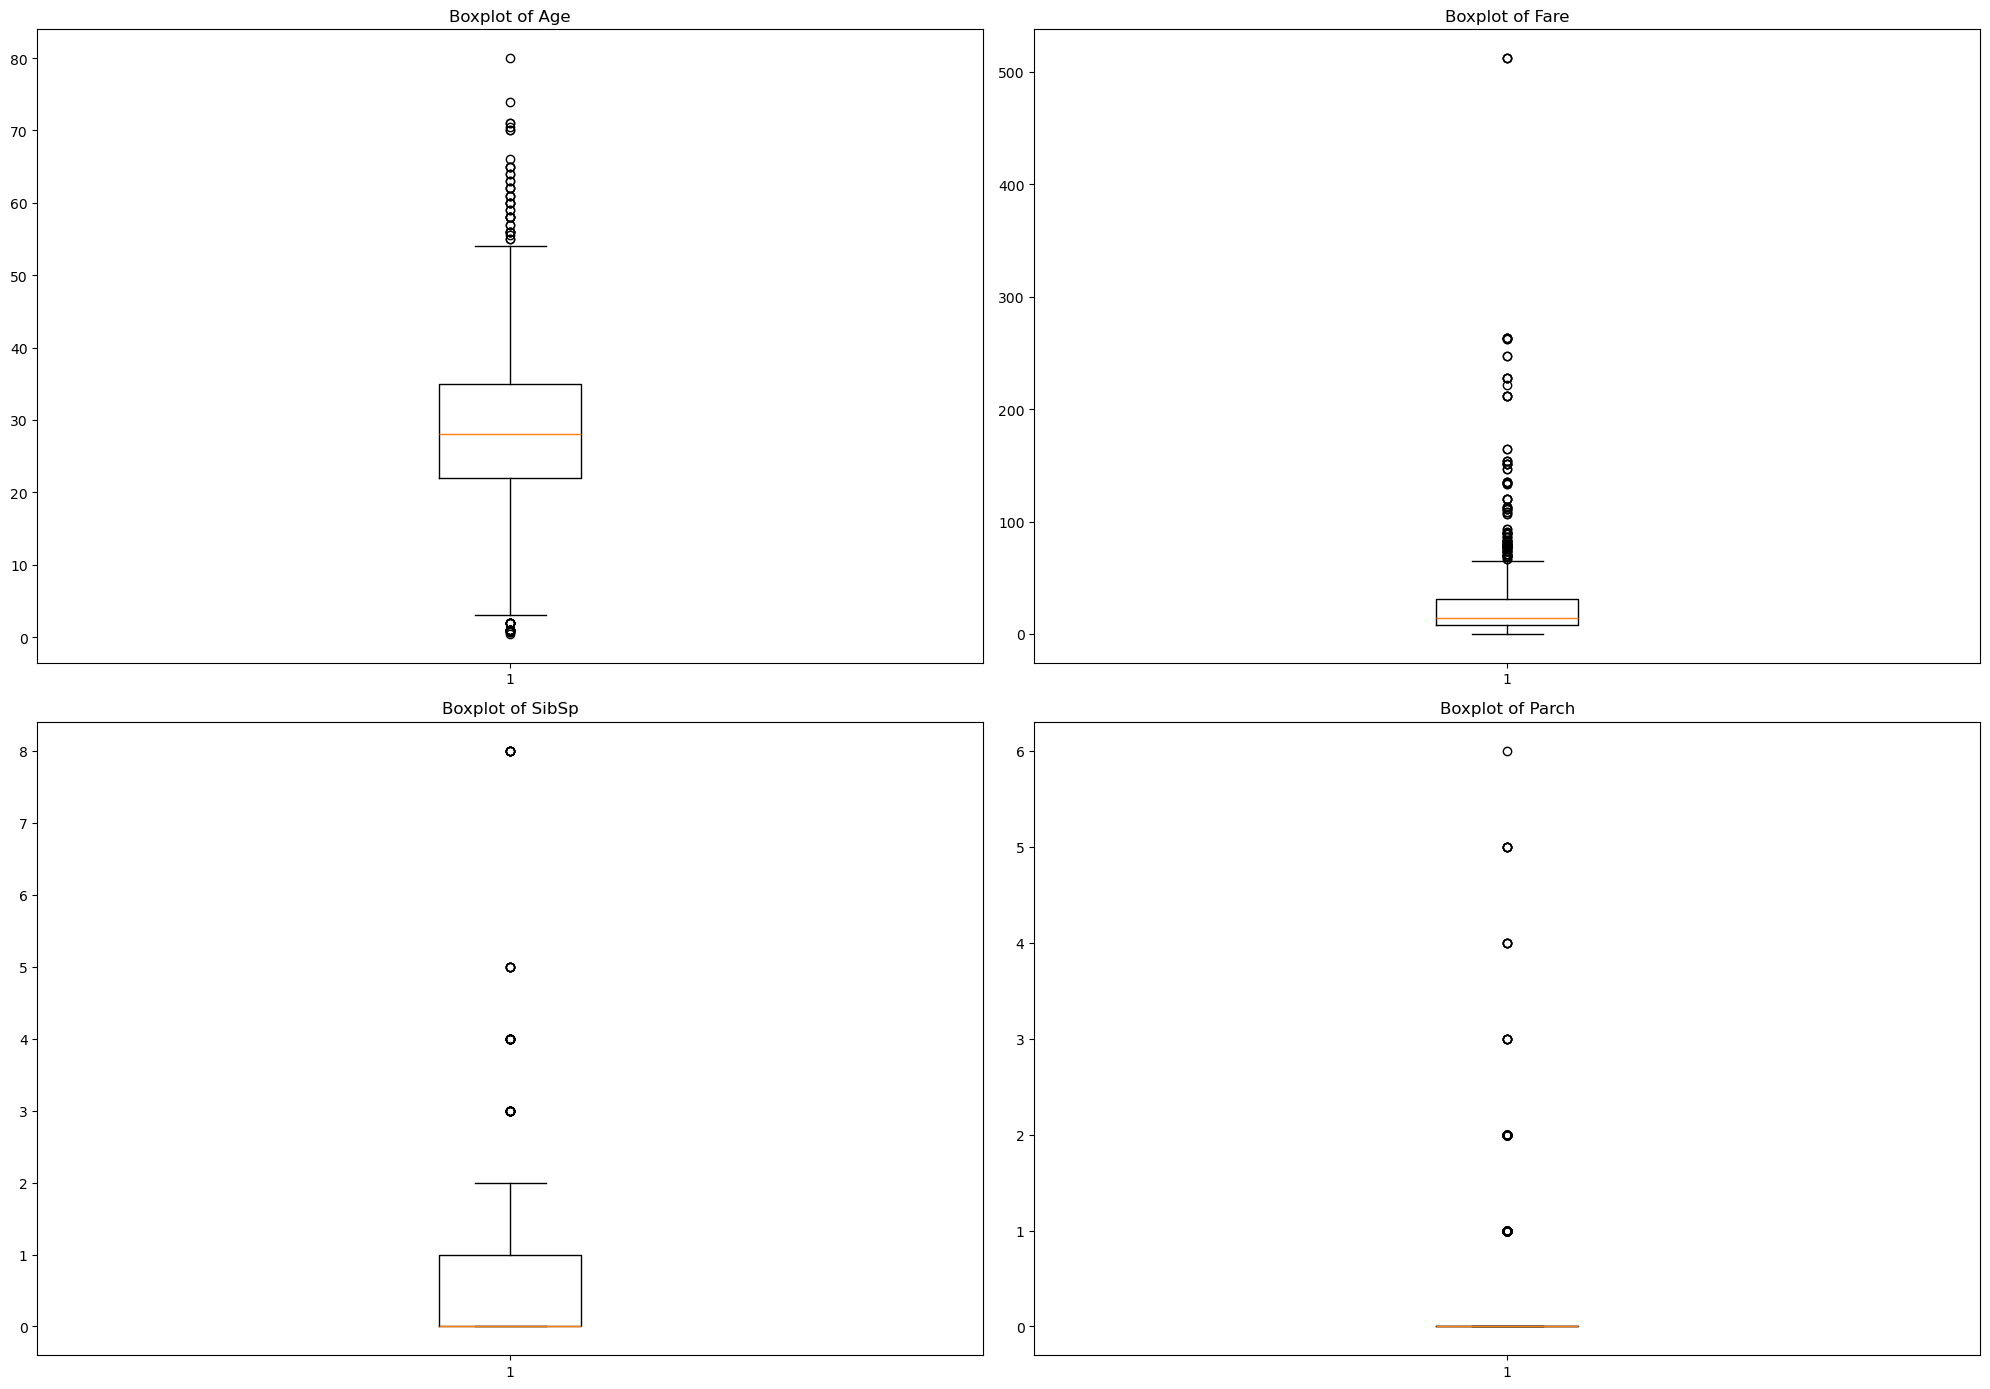

In [12]:
# Usando Boxplot para identificar outliers

fig, ax = plt.subplots(2,2,figsize=(20, 14))
ax[0,0].set_title('Boxplot of Age')
ax[0,0].boxplot(train['Age'])

ax[0,1].set_title('Boxplot of Fare')
ax[0,1].boxplot(x=train['Fare'])

ax[1,0].set_title('Boxplot of SibSp')
ax[1,0].boxplot(x=train['SibSp'])

ax[1,1].set_title('Boxplot of Parch')
ax[1,1].boxplot(x=train['Parch'])
plt.tight_layout()
plt.show()

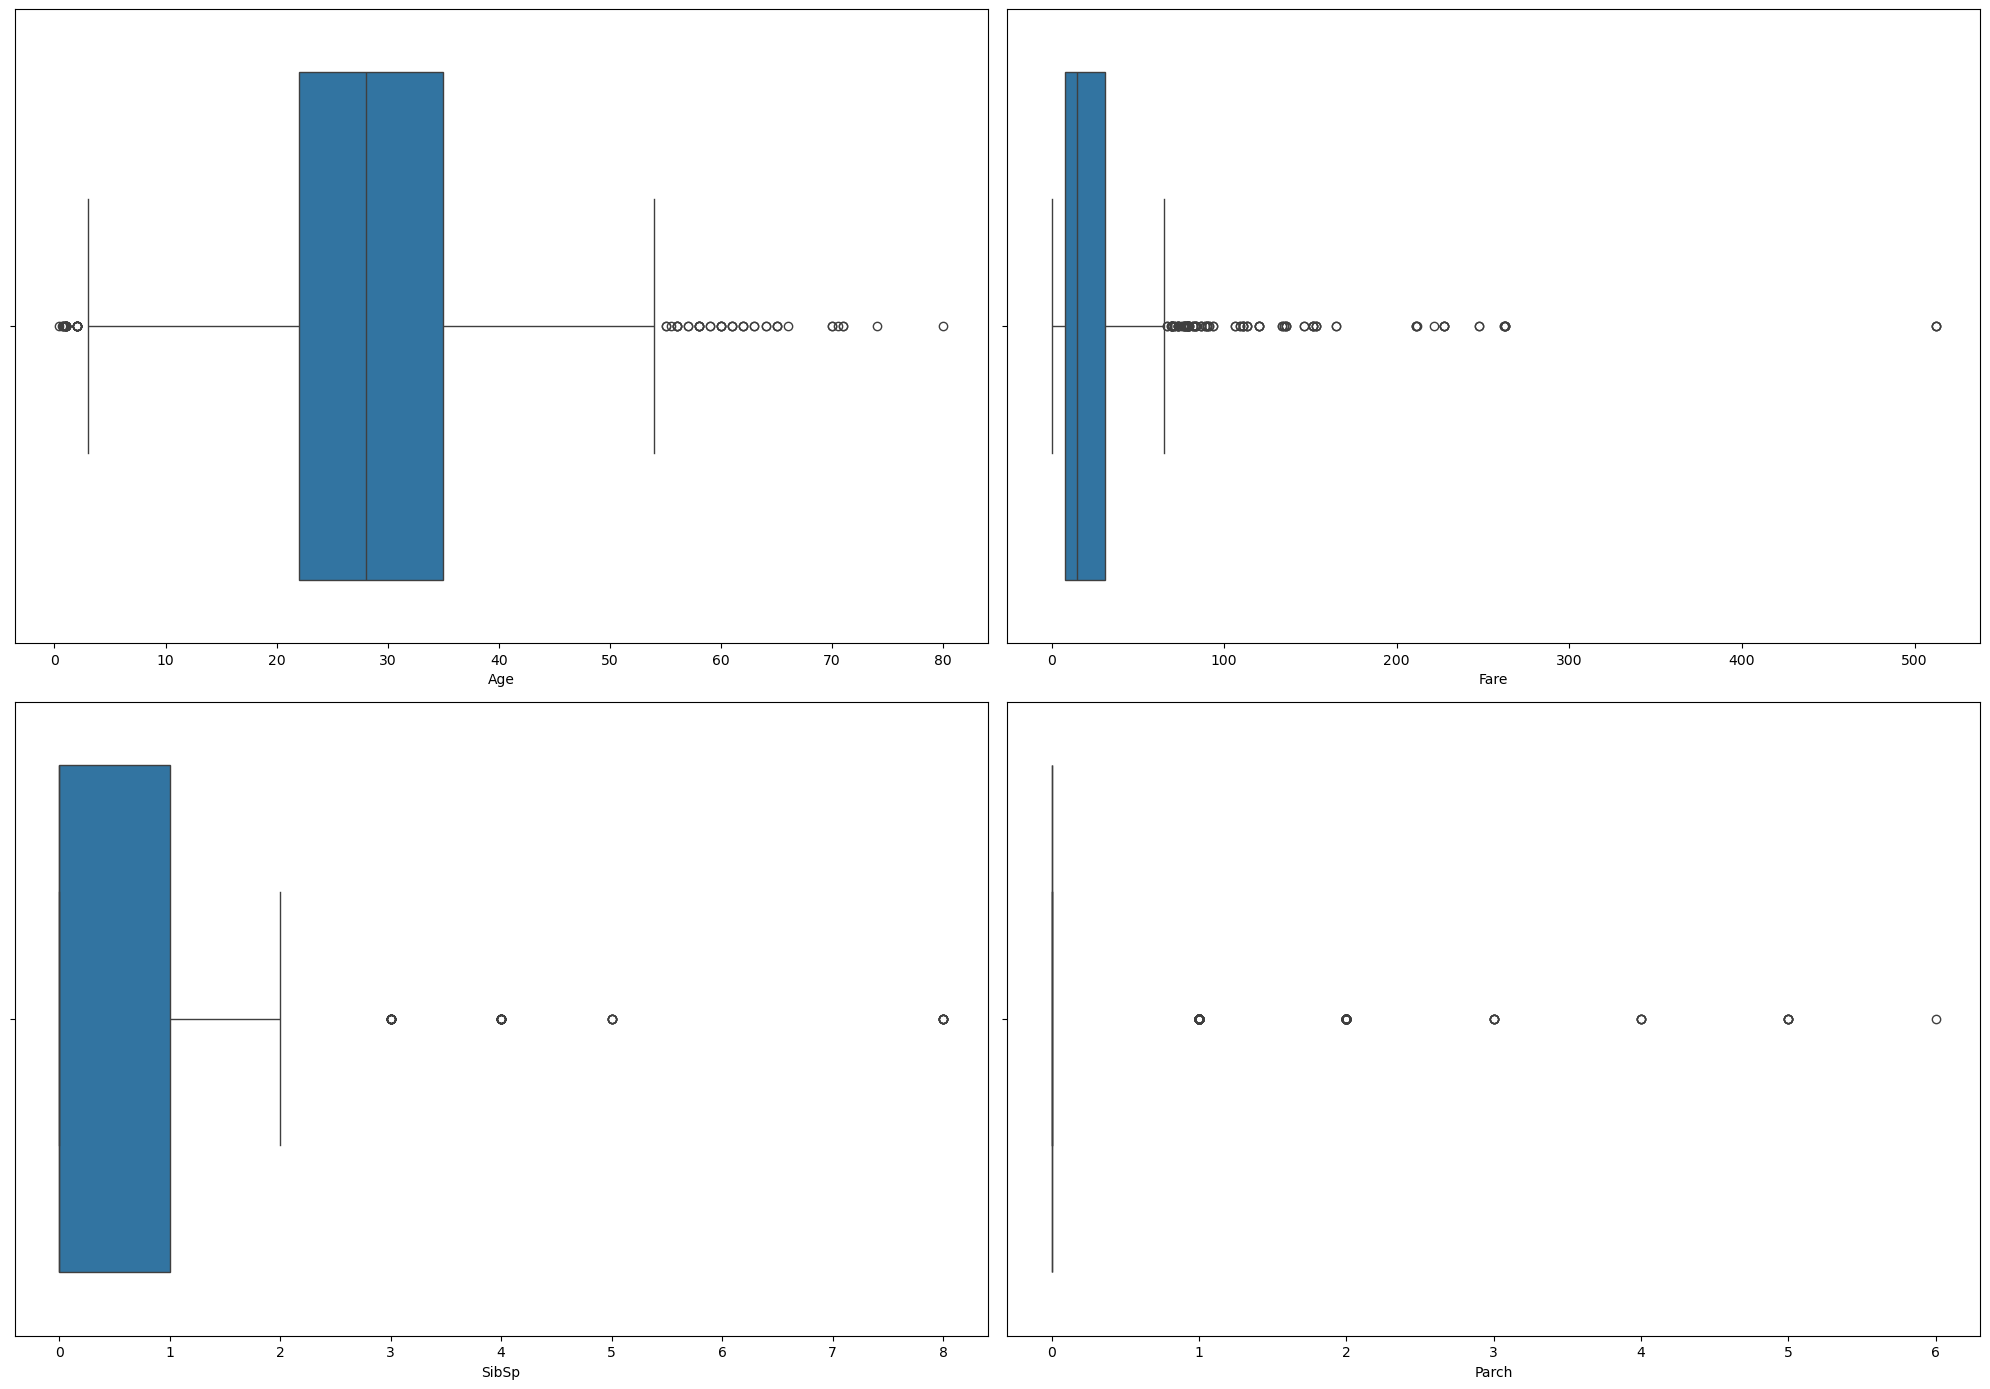

In [13]:
# Usando Seaborn para visualizar os outliers
fig, ax = plt.subplots(2,2,figsize=(20, 14))
sns.boxplot(x=train['Age'], ax=ax[0,0])
sns.boxplot(x=train['Fare'], ax=ax[0,1])
sns.boxplot(x=train['SibSp'], ax=ax[1,0])
sns.boxplot(x=train['Parch'], ax=ax[1,1])
plt.tight_layout()
plt.show()

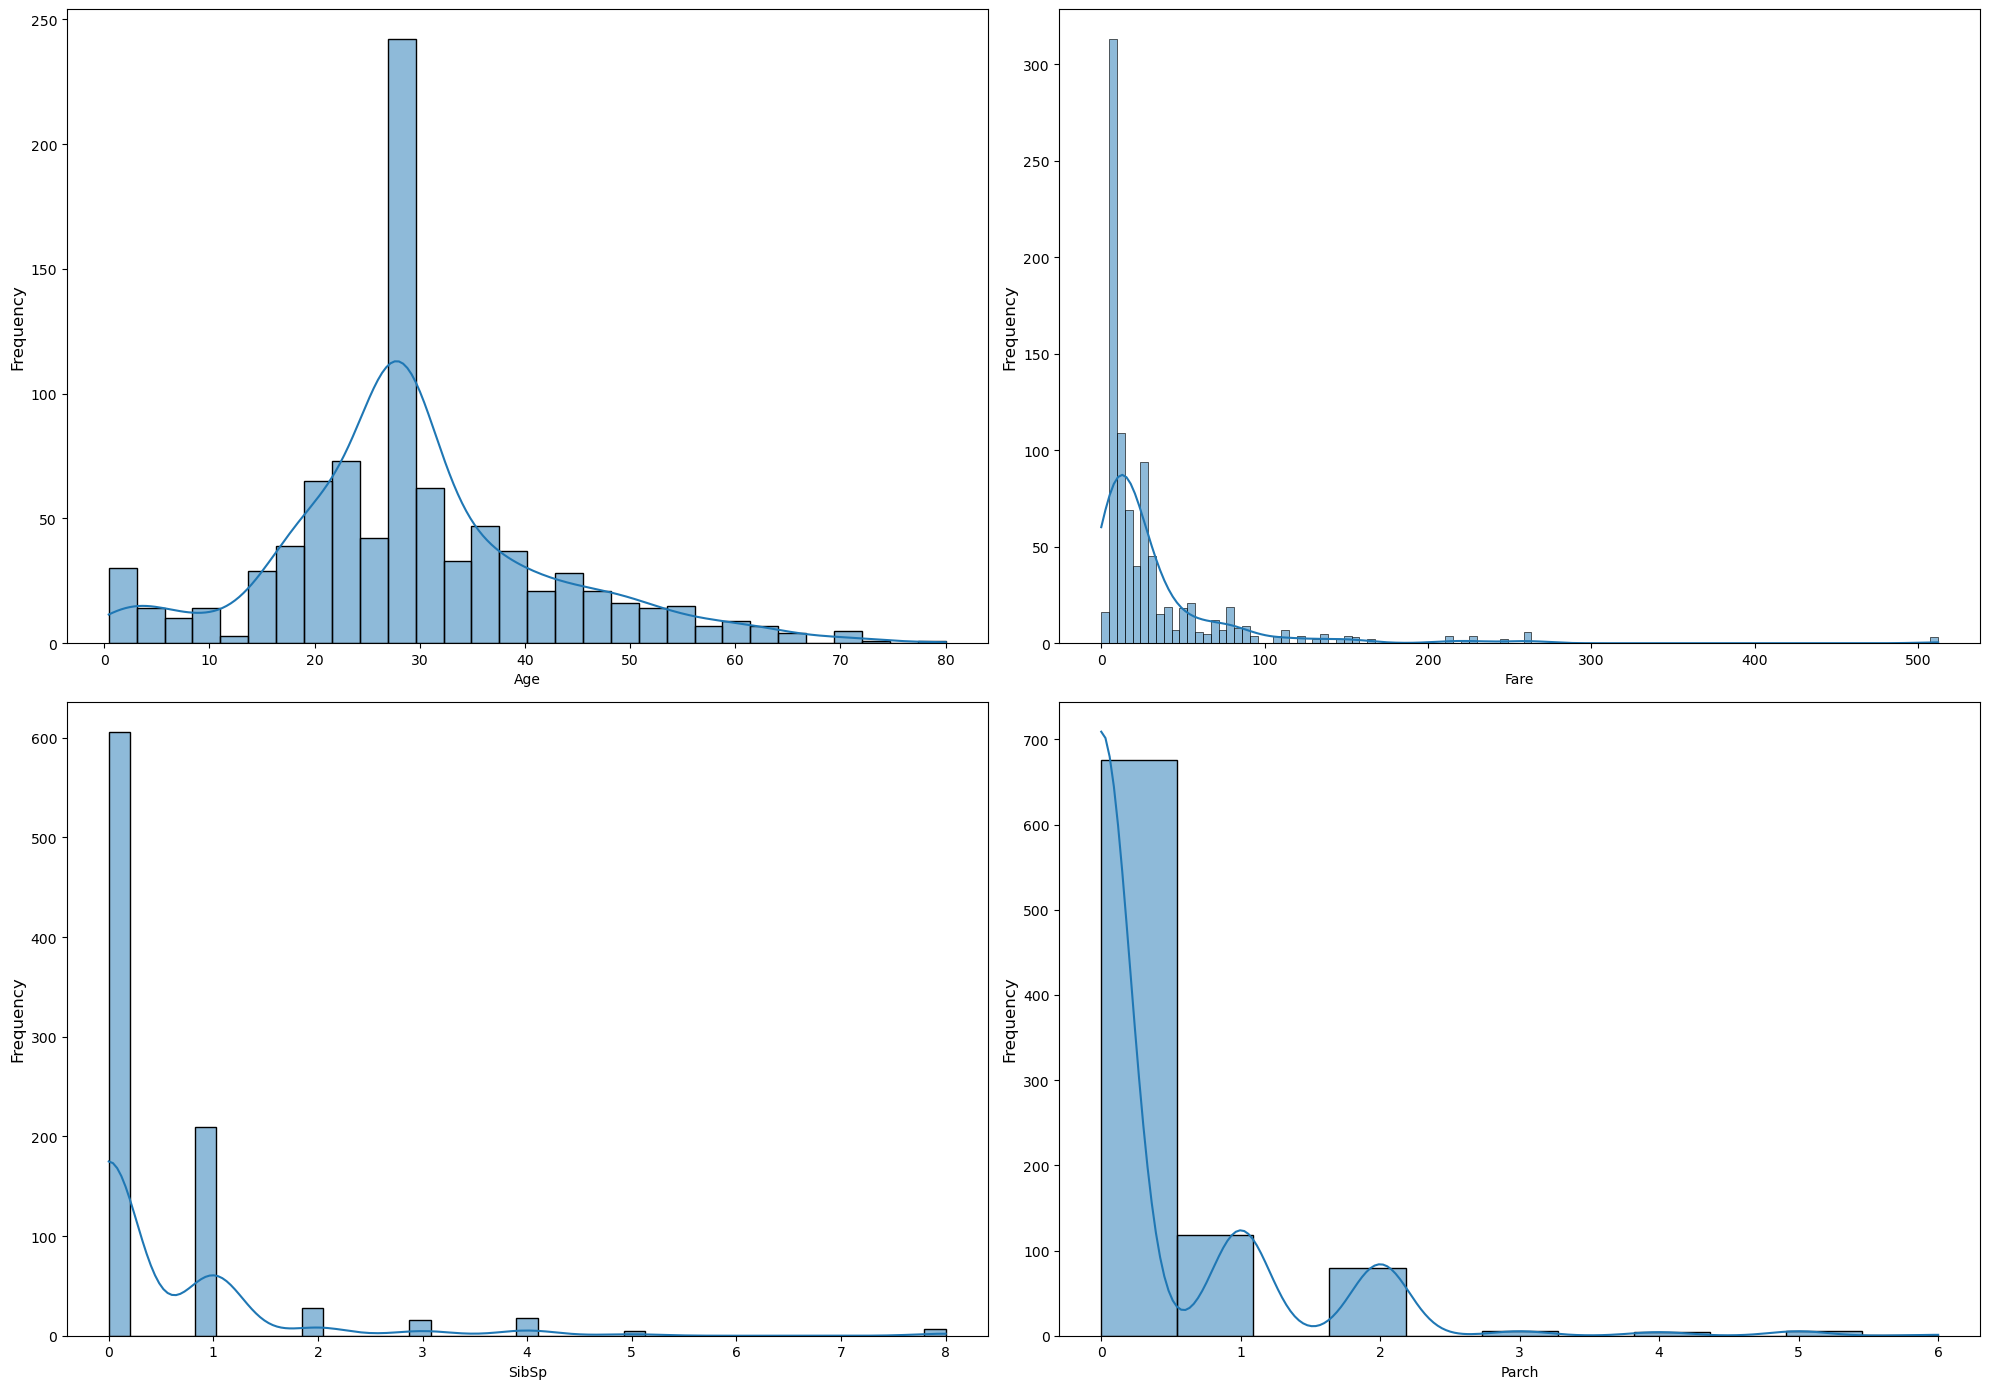

In [14]:
fig, ax = plt.subplots(2,2,figsize=(20, 14))
sns.histplot(train['Age'], ax=ax[0,0], kde=True)
sns.histplot(train['Fare'], ax=ax[0,1], kde=True)
sns.histplot(train['SibSp'], ax=ax[1,0], kde=True)
sns.histplot(train['Parch'], ax=ax[1,1], kde=True)

for axis in ax.flat:
    axis.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

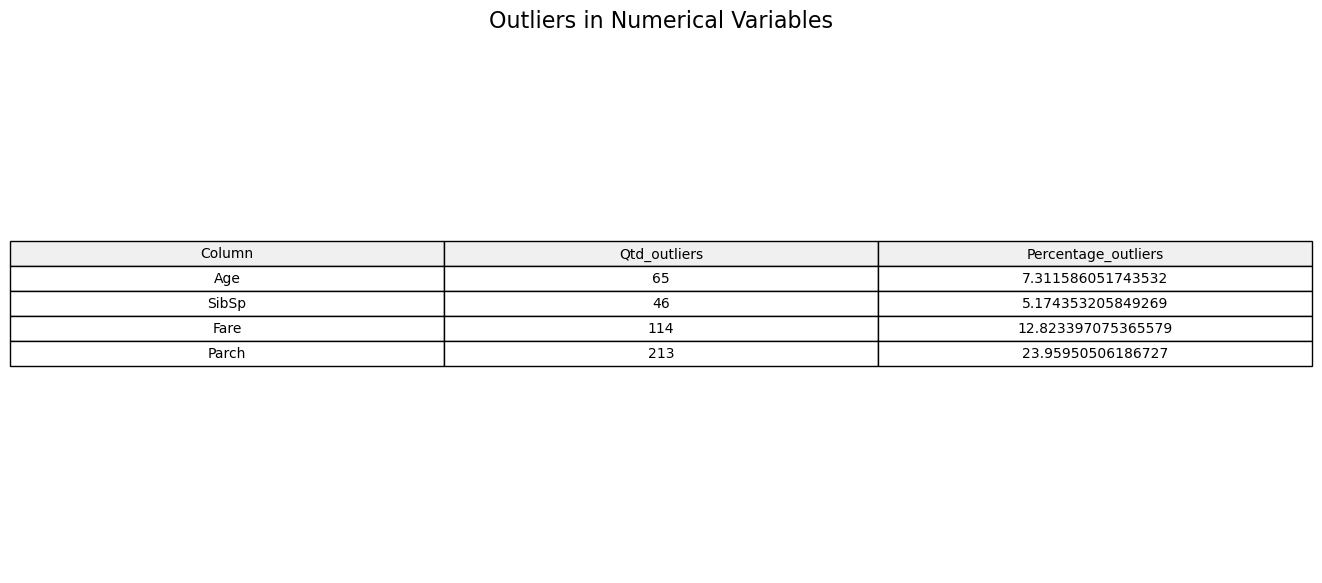

In [15]:
train_outliers = train[['Age','SibSp','Fare','Parch']]
train_outliers = calculate_outliers(train_outliers)

figure, ax = plt.subplots(figsize=(14, 7))
ax.axis('off')
table = plt.table(
    cellText=train_outliers.values,
    colLabels=train_outliers.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0'] * len(train_outliers.columns),
    
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Outliers in Numerical Variables", fontsize=16,pad = 5)
plt.show()

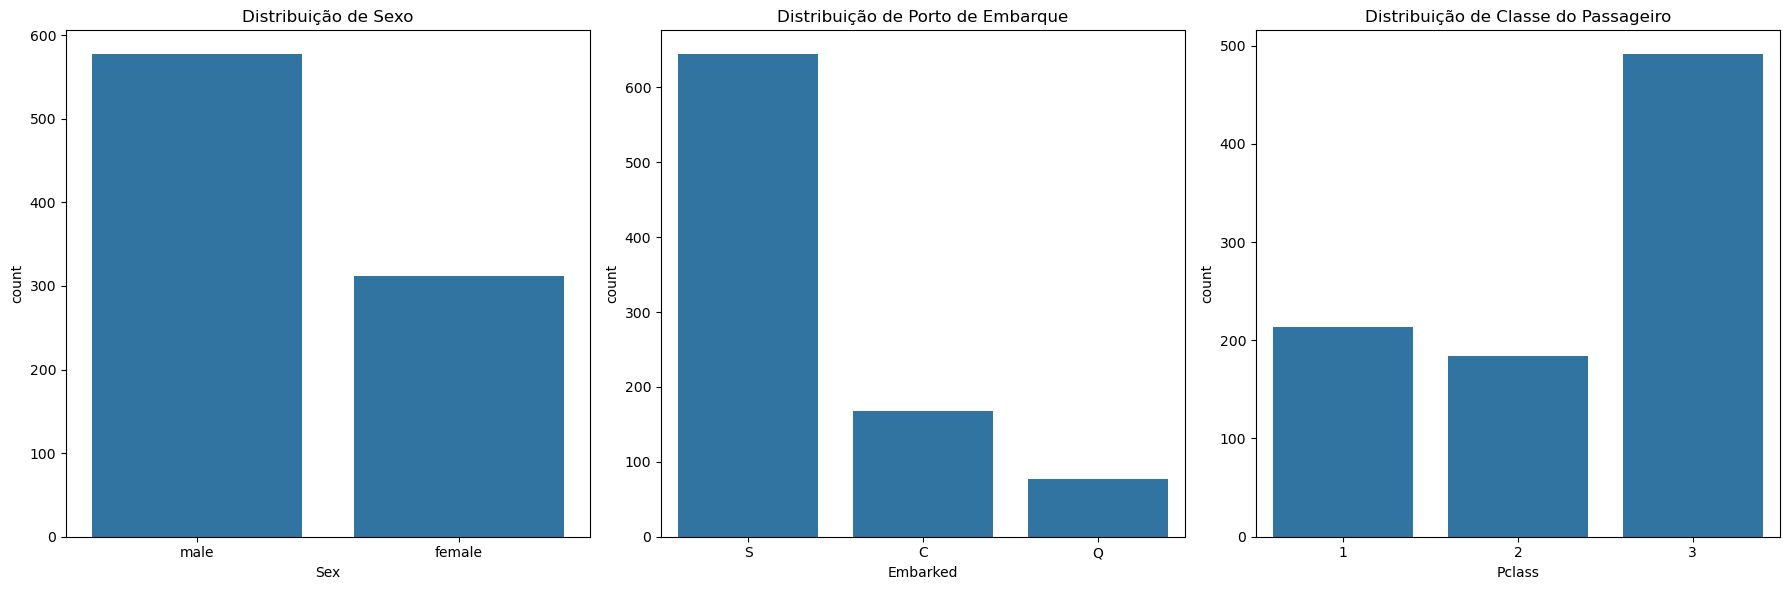

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='Sex', data=train, ax=axes[0])
axes[0].set_title('Distribuição de Sexo')
sns.countplot(x='Embarked', data=train, ax=axes[1])
axes[1].set_title('Distribuição de Porto de Embarque')
sns.countplot(x='Pclass', data=train, ax=axes[2])
axes[2].set_title('Distribuição de Classe do Passageiro')
plt.tight_layout()
plt.show()

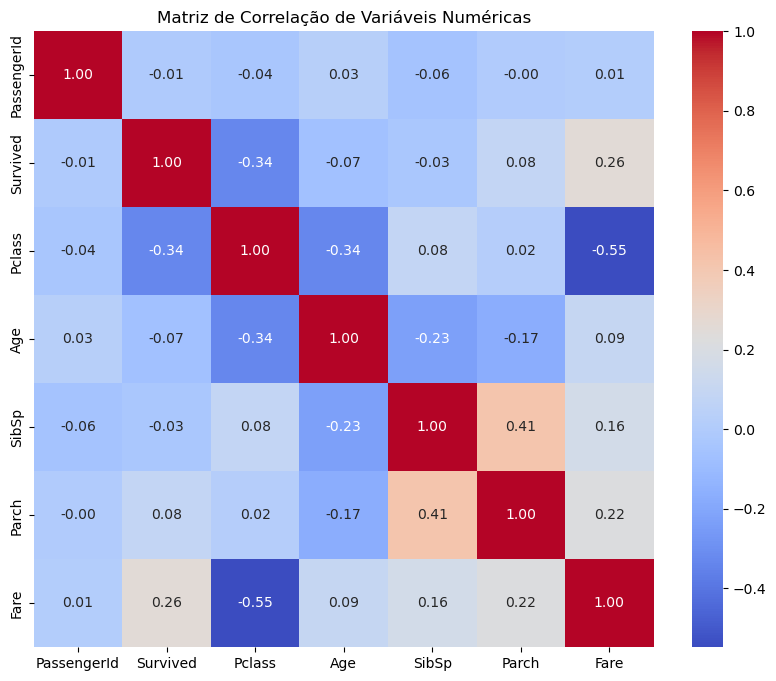

In [17]:
numeric_columns = train.select_dtypes(include=['int', 'float']).columns.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(train[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação de Variáveis Numéricas')
plt.show()

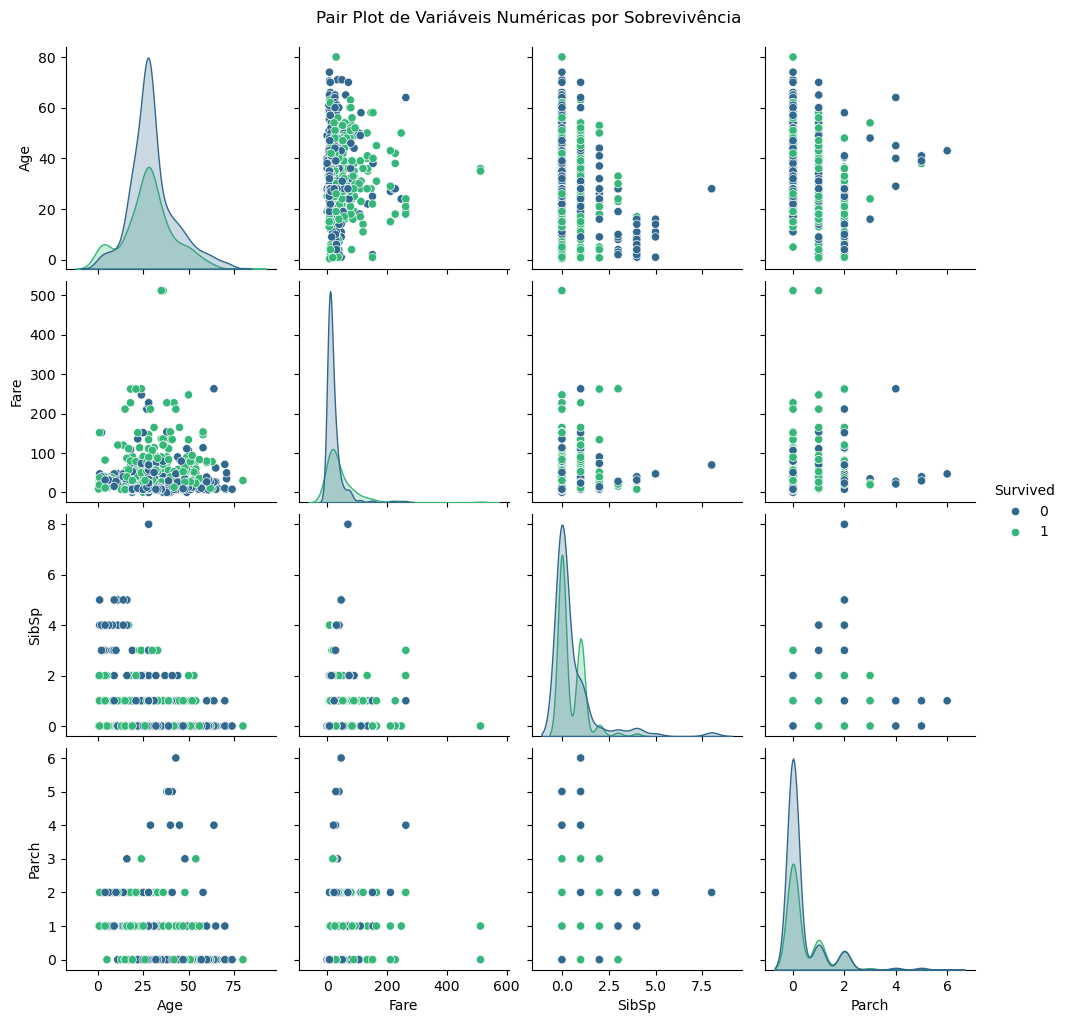

In [18]:
sns.pairplot(train[['Age', 'Fare', 'SibSp', 'Parch', 'Survived']], hue='Survived', palette='viridis')
plt.suptitle('Pair Plot de Variáveis Numéricas por Sobrevivência', y=1.02)
plt.show()

Lidando com variáveis categóricas

In [19]:
train_dummies = pd.get_dummies(train, columns=['Sex'], drop_first=True)
train_dummies 

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,U,S,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,U,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,U,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,U,S,True
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,S,False
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,W./C. 6607,23.4500,U,S,False
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,C,True


In [20]:
train['Sex'] = train_dummies['Sex_male']
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",True,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",False,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",True,35.0,0,0,373450,8.0500,U,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",True,27.0,0,0,211536,13.0000,U,S
887,888,1,1,"Graham, Miss. Margaret Edith",False,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",False,28.0,1,2,W./C. 6607,23.4500,U,S
889,890,1,1,"Behr, Mr. Karl Howell",True,26.0,0,0,111369,30.0000,C148,C


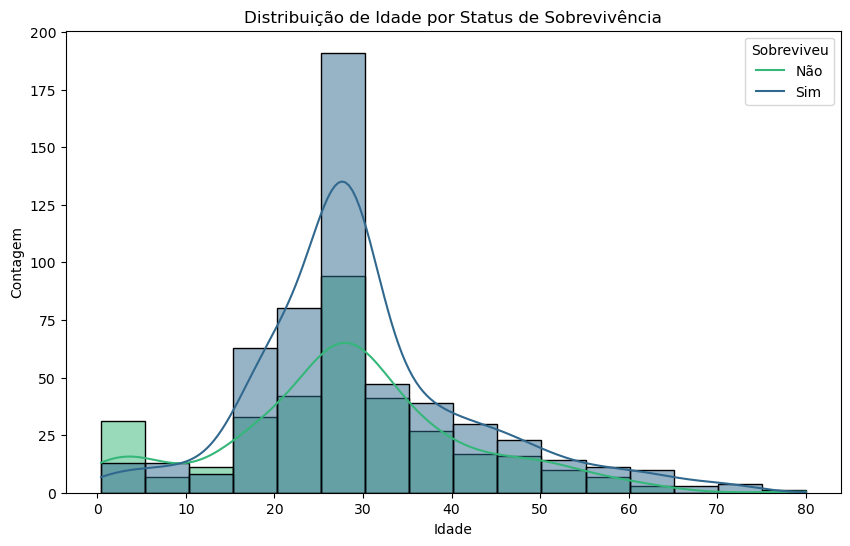

In [21]:
#Histogram/KDE plot of Age by Survived status
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='Age', hue='Survived', kde=True, palette='viridis',
             binwidth=5)
plt.title('Distribuição de Idade por Status de Sobrevivência')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.legend(title='Sobreviveu', labels=['Não', 'Sim'])
plt.show()


/tmp/ipykernel_1976/1369077478.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeGroup', y='Survived', data=train, palette='viridis')


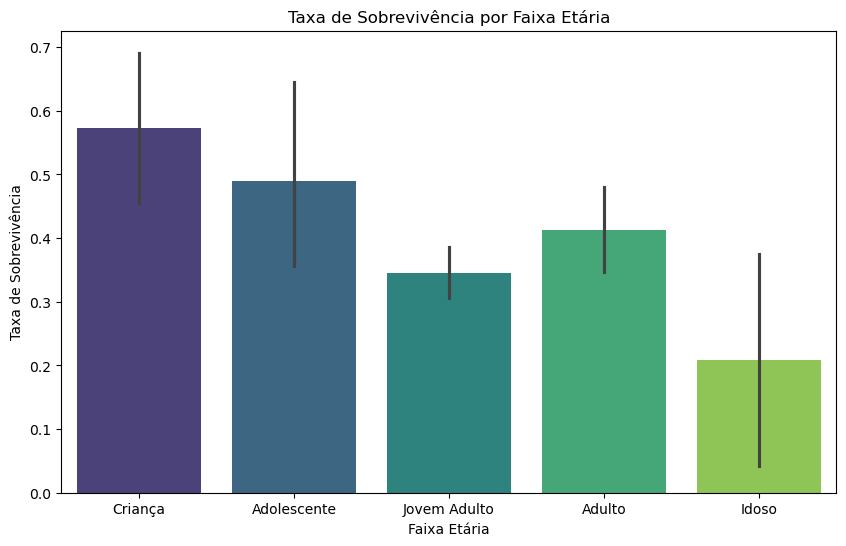

In [22]:
#Survival Rate by Age Bins
# Define age bins
bins = [0, 12, 18, 35, 60, 80]
labels = ['Criança', 'Adolescente', 'Jovem Adulto', 'Adulto', 'Idoso']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Survived', data=train, palette='viridis')
plt.title('Taxa de Sobrevivência por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de Sobrevivência')
plt.show()

# Clean up the temporary 'AgeGroup' column if you don't need it further
train = train.drop(columns=['AgeGroup'])

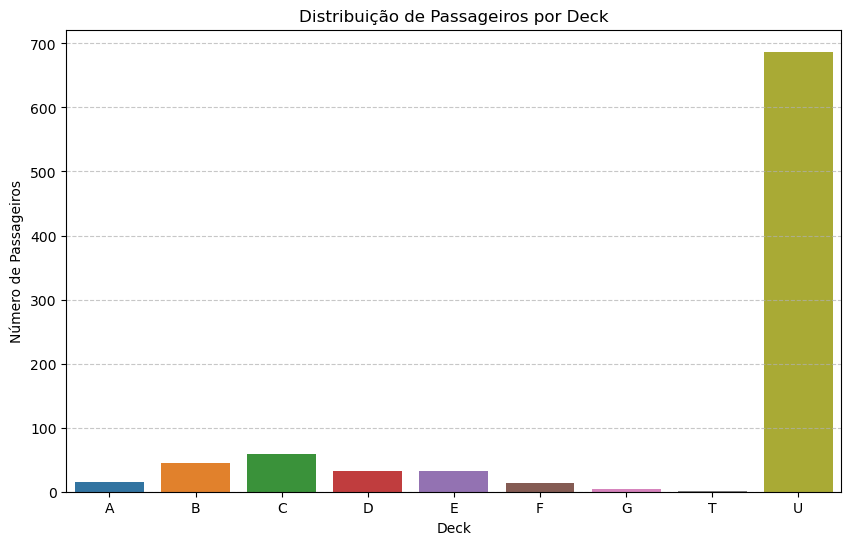

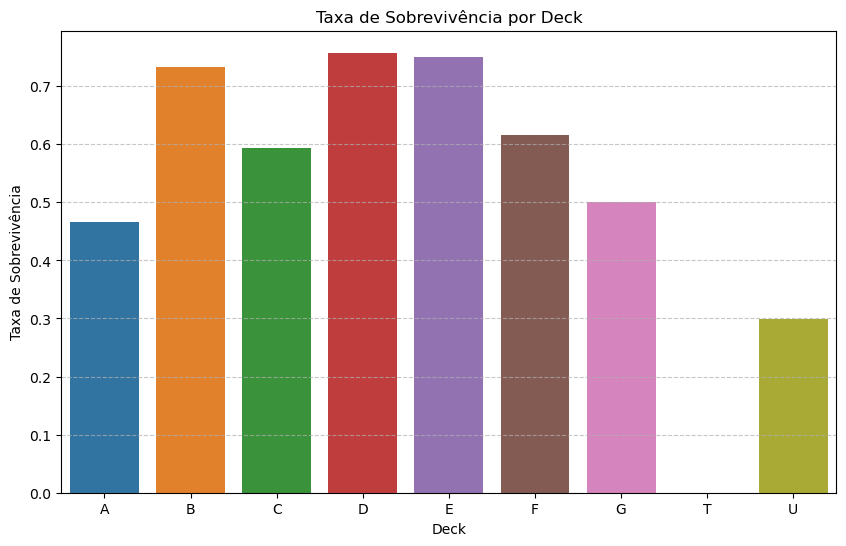

In [23]:
train['Deck'] = train['Cabin'].apply(lambda x: x[0])
deck_order = sorted(train['Deck'].unique())

deck_survival_rate = train.groupby('Deck')['Survived'].mean().reset_index()
deck_survival_rate.columns = ['Deck', 'Taxa']

deck_counts = train['Deck'].value_counts().reindex(deck_order)
deck_df = pd.DataFrame({'Deck': deck_counts.index, 'Count': deck_counts.values})

# Distribuição de Passageiros por Deck
plt.figure(figsize=(10, 6))
sns.barplot(data=deck_df,x='Deck', y='Count',hue='Deck',legend=False) 
plt.title('Distribuição de Passageiros por Deck')
plt.xlabel('Deck')
plt.ylabel('Número de Passageiros')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Taxa de Sobrevivência por Deck
plt.figure(figsize=(10, 6))
sns.barplot(data= deck_survival_rate,x='Deck', y='Taxa', hue='Deck',legend=False)
plt.title('Taxa de Sobrevivência por Deck')
plt.xlabel('Deck')
plt.ylabel('Taxa de Sobrevivência')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Regressão Linear

In [24]:
encoder = LabelEncoder()

In [25]:
df_regression = train.drop(['PassengerId','Name','Ticket','Cabin', 'Embarked'],axis=1)
df_regression['Deck'] = encoder.fit_transform(df_regression['Deck'])
df_regression['Pclass'] = encoder.fit_transform(df_regression['Pclass'])

In [26]:
x = df_regression.drop(['Survived'], axis=1)
y = df_regression['Survived']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [28]:
sd = StandardScaler()
x_train = sd.fit_transform(x_train)
x_test = sd.fit_transform(x_test)


In [29]:
classifier = LogisticRegression(random_state=0)
classifier.fit(x_train, y_train)


LogisticRegression(random_state=0)

In [30]:
y_pred = classifier.predict(x_test)

In [31]:
print(accuracy_score(y_test, y_pred))
conf_m = confusion_matrix(y_test, y_pred)

0.8164794007490637


<Axes: >

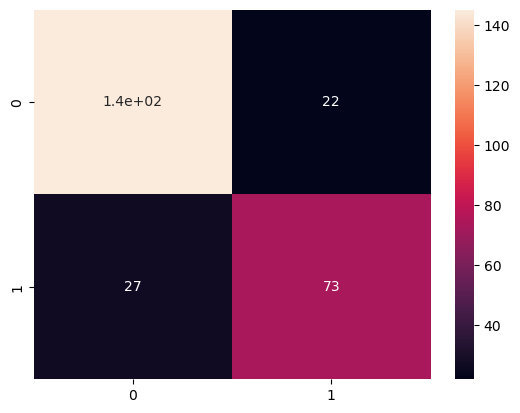

In [32]:
sns.heatmap(conf_m, annot=True)

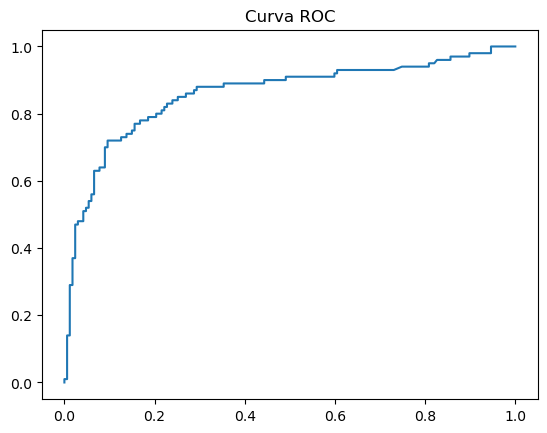

In [33]:
# Plotar roc curv
prob = classifier.predict_proba(x_test)
prob = prob[:,1]
fpr, tpr, trash = roc_curve(y_test, prob)

plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.show()


In [34]:
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))


0.7684210526315789
0.73
0.7487179487179487


Klusterização

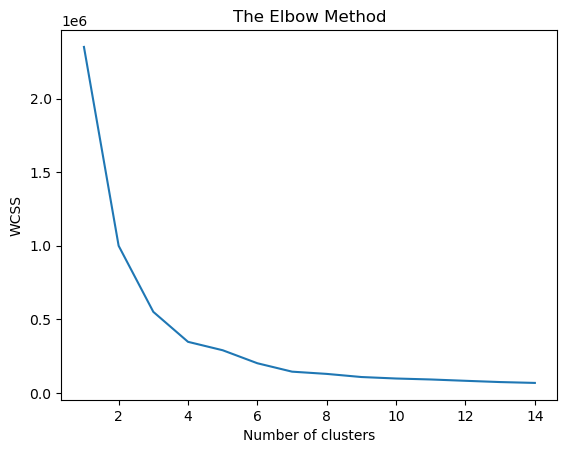

In [35]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_regression)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<Axes: xlabel='Fare', ylabel='Deck'>

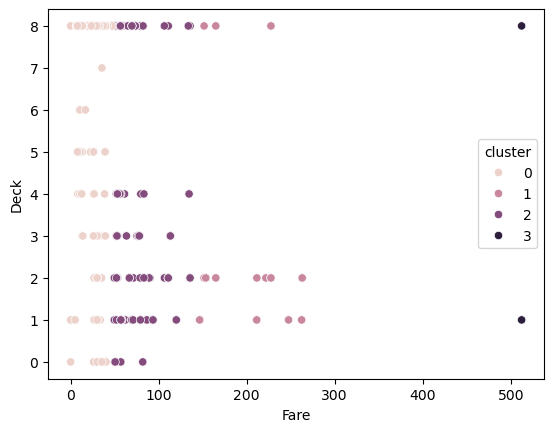

In [36]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df_regression)
df_regression['cluster'] = y_kmeans
sns.scatterplot(data = df_regression, x = 'Fare', y =  'Deck', hue = 'cluster')

Decision Tree

In [37]:
modelo = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20, criterion='gini')

modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

In [38]:
print(accuracy_score(y_test, y_pred))

0.8352059925093633


Text(50.722222222222214, 0.5, 'y_pred')

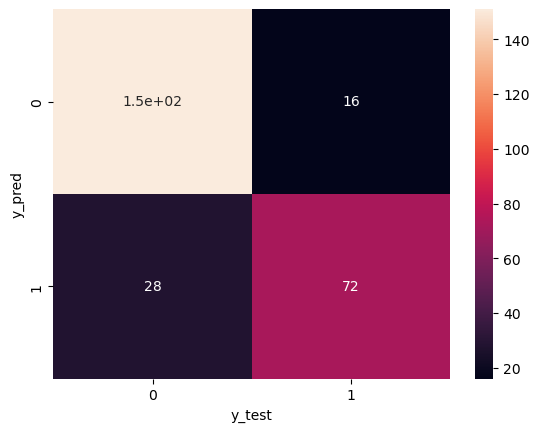

In [39]:
conf_m = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_m, annot=True)
plt.xlabel('y_test')
plt.ylabel('y_pred')


Random Forest

In [40]:
modelo = RandomForestClassifier(max_depth=10, max_leaf_nodes=20,n_estimators=10, random_state=42)

modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

In [41]:
print(accuracy_score(y_test, y_pred))

0.8202247191011236


Text(50.722222222222214, 0.5, 'y_pred')

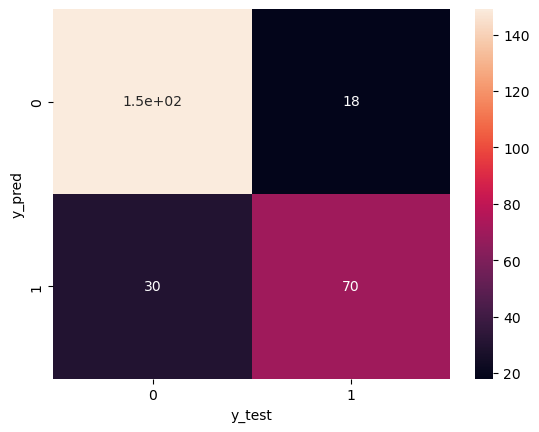

In [42]:
conf_m = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_m, annot=True)
plt.xlabel('y_test')
plt.ylabel('y_pred')